# Assignment 2
The objective of this assignment is to get you familiarizewith  the  problems  of  `classification`  and  `verification`with a popular problem space of `face`

This jupyter notebook is meant to be used in conjunction with the full questions in the assignment pdf.

## Instructions
- Write your code and analyses in the indicated cells.
- Ensure that this notebook runs without errors when the cells are run in sequence.
- Do not attempt to change the contents of the other cells.

## Allowed Libraries
- All libraries are allowed 

## Datasets 
- 3 datasets are provided. Load the data from the drive [link](!https://drive.google.com/file/d/1ujsKv9W5eidb4TXt1pnsqwDKVDFtzZTh/view?usp=sharing).
- Unzip the downloaded file and store the files in a folder called `datasets`. Keep the `datasets` folder in the same directory as of the jupyter notebook 

## Submission
- Ensure that this notebook runs without errors when the cells are run in sequence.
- Rename the notebook to `<roll_number>.ipynb` and submit ONLY the notebook file on moodle.
- Upload  the  notebook,  report  and  classification  results as a zip file to moodle. Name the zip file as `<rollnumber>_assignment2.zip`

In [123]:
# Installing Libraries
!pip install scikit-learn matplotlib Pillow

In [124]:
# Basic Imports
import os
import sys
import warnings
import numpy as  np
import pandas as pd
from scipy import linalg

# Loading and plotting data
from PIL import Image
import matplotlib.pyplot as plt 
from mpl_toolkits.mplot3d import Axes3D

# Features
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
from sklearn.discriminant_analysis import _class_means,_class_cov
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split

#classification models
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,precision_score,recall_score,f1_score
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier


from IPython.display import display,Markdown
import seaborn as sns
from sklearn.model_selection import KFold

import warnings
warnings.filterwarnings('ignore')

plt.ion()
%matplotlib inline

# Parameters
- Image size: Bigger images create better representation but would require more computation. Choose the correct image size based on your Laptop configuration. 
- is_grayscale: Should you take grayscale images? Or rgb images? Choose whichever gives better representation for classification. 

In [125]:
opt = {
    'image_size': 32,
    'is_grayscale': False,
    'val_split': 0.75
}

### Load Dataset

In [126]:
cfw_dict = {'Amitabhbachan': 0,
    'AamirKhan': 1,
    'DwayneJohnson': 2,
    'AishwaryaRai': 3,
    'BarackObama': 4,
    'NarendraModi': 5,
    'ManmohanSingh': 6,
    'VladimirPutin': 7}

imfdb_dict = {'MadhuriDixit': 0,
     'Kajol': 1,
     'SharukhKhan': 2,
     'ShilpaShetty': 3,
     'AmitabhBachan': 4,
     'KatrinaKaif': 5,
     'AkshayKumar': 6,
     'Amir': 7}

# Load Image using PIL for dataset
def load_image(path):
    im = Image.open(path).convert('L' if opt['is_grayscale'] else 'RGB')
    im = im.resize((opt['image_size'],opt['image_size']))
    im = np.array(im)
    im = im/256
    return im

# Load the full data from directory
def load_data(dir_path):
    image_list = []
    y_list = []
    
    if "CFW" in dir_path:
        label_dict = cfw_dict

    elif "yale" in dir_path.lower():
        label_dict = {}
        for i in range(15):
            label_dict[str(i+1)] = i
    elif "IMFDB" in dir_path:
        label_dict = imfdb_dict
    else:
        raise KeyError("Dataset not found.")
    
    
    for filename in sorted(os.listdir(dir_path)):
        if filename.endswith(".png"):
            im = load_image(os.path.join(dir_path,filename))
            y = filename.split('_')[0]
            y = label_dict[y] 
            image_list.append(im)
            y_list.append(y)
        else:
            continue

    image_list = np.array(image_list)
    y_list = np.array(y_list)

    print("Dataset shape:",image_list.shape)

    return image_list,y_list

# Display N Images in a nice format
def disply_images(imgs,classes,row=1,col=2,w=64,h=64):
    fig=plt.figure(figsize=(8, 8))
    for i in range(1, col*row +1):
        img = imgs[i-1]
        fig.add_subplot(row, col, i)
        
        if opt['is_grayscale']:
            plt.imshow(img , cmap='gray') 
        else:
            plt.imshow(img)
        
        plt.title("Class:{}".format(classes[i-1]))
        plt.axis('off')
    plt.show()

In [127]:
# Loading the dataset
dirpath = './dataset/IMFDB/'
X,y = load_data(dirpath)
N,H,W = X.shape[0:3]
C = 1 if opt['is_grayscale'] else X.shape[3]


dirpath = './dataset/IIIT-CFW/'
X_IIIT, y_IIIT = load_data(dirpath)
N1, H1, W1 = X_IIIT.shape[0:3]
if opt['is_grayscale']:
    C1 = 1
else:
    C1 = X_IIIT.shape[3]

dirpath = './dataset/IMFDB/'
X_IMFDB, y_IMFDB = load_data(dirpath)
N2, H2, W2 = X_IMFDB.shape[0:3]
if opt['is_grayscale']:
    C2 = 1
else:
    C2 = X_IMFDB.shape[3]

dirpath = './dataset/Yale_face_database/'
X_Yale, y_Yale = load_data(dirpath)
N3, H3, W3 = X_Yale.shape[0:3]
if opt['is_grayscale']:
    C3 = 1
else:
    C3 = X_Yale.shape[3]

Dataset shape: (400, 32, 32, 3)
Dataset shape: (672, 32, 32, 3)
Dataset shape: (400, 32, 32, 3)
Dataset shape: (165, 32, 32, 3)


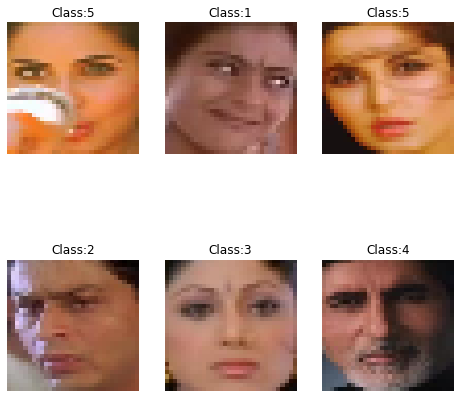

In [128]:
# Show sample images
ind = np.random.randint(0,y.shape[0],6)
disply_images(X[ind,...],y[ind], row=2,col=3)

# Features
    You are provided 6 Features. These features are:
   - Eigen Faces / PCA 
   - Kernel PCA
   - Fisher Face / LDA
   - Kernel Fisher Face
   - VGG Features 
   - Resnet Features

**VGG and Resnet features are last layer features learned by training a model for image classification**
    
---


In [129]:
# Flatten to apply PCA/LDA
X = X.reshape((N,H*W*C))

In [130]:
X_IIIT = X_IIIT.reshape((N1, H1*W1*C1))
X_IMFDB = X_IMFDB .reshape((N2, H2*W2*C2))
X_Yale = X_Yale.reshape((N3, H3*W3*C3))

###  1. Eigen Face:
Use principal component analysis to get the eigen faces. 
Go through the [documentation](!http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) on how to use it

In [131]:
def get_pca(X,k):
    """
        Get PCA of K dimension using the top eigen vectors 
    """
    pca = PCA(n_components=k)
    X_k = pca.fit_transform(X)
    return X_k

###  2. Kernel Face:
Use Kernel principal component analysis to get the eigen faces. 

There are different kernels that can be used. Eg. Poly, rbf, sigmoid. Choose the whichever gives the best result or representation. See [link](!https://data-flair.training/blogs/svm-kernel-functions/) for better understanding of these kernels  

Go through the [documentation](!https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.KernelPCA.html#sklearn.decomposition.KernelPCA) on how to use it different kernels in Sklearn. 

In [132]:
def get_kernel_pca(X, k,kernel='rbf', degree=3):
    """
        Get PCA of K dimension using the top eigen vectors 
        @param: X => Your data flattened to D dimension
        @param: k => Number of components
        @param: kernel => which kernel to use (“linear” | “poly” | “rbf” | “sigmoid” | “cosine” )
        @param: d => Degree for poly kernels. Ignored by other kernels
    """
    kpca = KernelPCA(n_components=k,kernel=kernel,degree=degree)
    X_k = kpca.fit_transform(X)
    return X_k

### 3. Fisher Face
Another method similar to the eigenface technique is `fisherfaces` which uses linear discriminant analysis.
This method for facial recognition is less sensitive to variation in lighting and pose of the face than using eigenfaces. Fisherface uses labelled data to retain more of the class-specific information during the dimension reduction stage.

Go through the [documentation](!https://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.LinearDiscriminantAnalysis.html) on how to use it different kernels in Sklearn. 

In [133]:
def get_lda(X,y, k):
    """
        Get LDA of K dimension 
        @param: X => Your data flattened to D dimension
        @param: k => Number of components
    """
    lda = LDA(n_components=k)
    X_k = lda.fit_transform(X,y)
    return X_k

### 4. Kernel Fisher Face
Use LDA using different kernels similiar to KernelPCA. Here the input is directly transformed instead of using the kernel trick.  

In [134]:
def get_kernel_lda(X,y,k,kernel='rbf',degree=3):
    """
        Get LDA of K dimension 
        @param: X => Your data flattened to D dimension
        @param: k => Number of components
        @param: kernel => which kernel to use ( “poly” | “rbf” | “sigmoid”)
    """
    # Transform  input
    if kernel == "poly":
        X_transformed = X**degree
    elif kernel == "rbf":
        var = np.var(X)
        X_transformed= np.exp(-X/(2*var))
    elif kernel == "sigmoid":
        X_transformed = np.tanh(X)
    else: 
        raise NotImplementedError("Kernel {} Not defined".format(kernel))
        
    klda = LDA(n_components=k)
    X_k = klda.fit_transform(X,y)
    return X_k

### 5. VGG Features
VGG Neural Networks a 19 layer CNN architecture introduced by Andrew Zisserman([Link](!https://arxiv.org/pdf/1409.1556.pdf) to paper). We are providing you with the last fully connected layer of this model.

The model was trained for face classification on each dataset and each feature the dimension of 4096.

In [135]:
def get_vgg_features(dirpath):
    features = np.load(os.path.join(dirpath,"VGG19_features.npy"))
    return features

### 6. Resnet Features

[Residual neural networks](!https://arxiv.org/pdf/1512.03385.pdf) are CNN with large depth, to effectively train these netwrorks they utilize skip connections, or short-cuts to jump over some layers. This helps solving [vanishing gradient problem](!https://en.wikipedia.org/wiki/Vanishing_gradient_problem) 

A 50 layer resnet model was trained for face classification on each dataset. Each feature the dimension of 2048

In [136]:
def get_resnet_features(dirpath):
    features = np.load(os.path.join(dirpath,"resnet50_features.npy"))
    return features

# Questions
1(a). What are eigen faces? 

___________________________

- Eigenfaces is what a set of eigenvectors are called when they are used in computer vision for the problem of human face recognition.
-  The eigenfaces are the principal components of a distribution of faces, or equivalently, the eigenvectors of the covariance matrix of the set of face images, where an image with N pixels is considered a point (or vector) in N-dimensional space.
- The aim is to extract the relevant facial information, which may or may not be directly related to human intuition of face features such as the eyes, nose, and lips. One way to do so is to capture the statistical variation between face images, which is what we do by capturing eigenfaces

 1(b).  How many eigen vec-tors/faces are required to “satisfactorily” reconstruct a  person  in  these  three  datasets? (Don’t  forget  to make your argument based on eigen value spectrum) Show appropriate graphs, qualitative examples andmake a convincing argument.

- I am assuming that 90% reconstruction is satisfactory
- I have calculated below the number of eigen vectors required to get <=10% loss
- I have plotted the pca plots and eigen value spectrums below for each dataset
- We can see that IIIT dataset has many significant eigen values, as compared to other datasets where first couple of eigen values are very big and the rest reach ~0 very quickly. Since IIIT dataset has more a more distributed eigen value spectrum, it requires more eigen vectors to reconstruct its images. The calculation done is consistent with this explanation. IIIT dataset requires 208 eigenvectors, while other datasets require only 67 and 35

In [137]:
# Compute your features 
PCA_IIIT = get_pca(X_IIIT, 3)
PCA_IMFDB = get_pca(X_IMFDB, 3)
PCA_Yale = get_pca(X_Yale, 3)

Text(0.5, 0.92, 'Dataset: Yale')

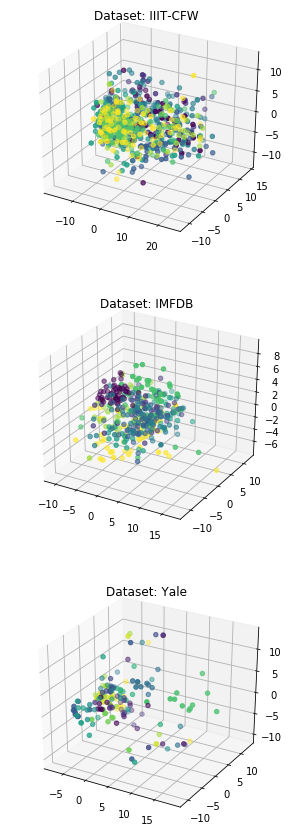

In [138]:
# Create a scatter plot  
fig = plt.figure(figsize=(5, 15))

ax = fig.add_subplot(311, projection='3d')
ax.scatter(PCA_IIIT[:,0], PCA_IIIT[:,1], PCA_IIIT[:,2], c = y_IIIT)
ax.set_title("Dataset: IIIT-CFW")

ax = fig.add_subplot(312, projection='3d')
ax.scatter(PCA_IMFDB[:,0], PCA_IMFDB[:,1], PCA_IMFDB[:,2], c = y_IMFDB)
ax.set_title("Dataset: IMFDB")

ax = fig.add_subplot(313, projection='3d')
ax.scatter(PCA_Yale[:,0], PCA_Yale[:,1], PCA_Yale[:,2], c = y_Yale)
ax.set_title("Dataset: Yale")

208  eigen vectors are enough to reconstruct the dataset with at most 10% loss for the IIIT CFW dataset
67  eigen vectors are enough to reconstruct the dataset with at most 10% loss for the IMFDB dataset
35  eigen vectors are enough to reconstruct the dataset with at most 10% loss for the Yale dataset


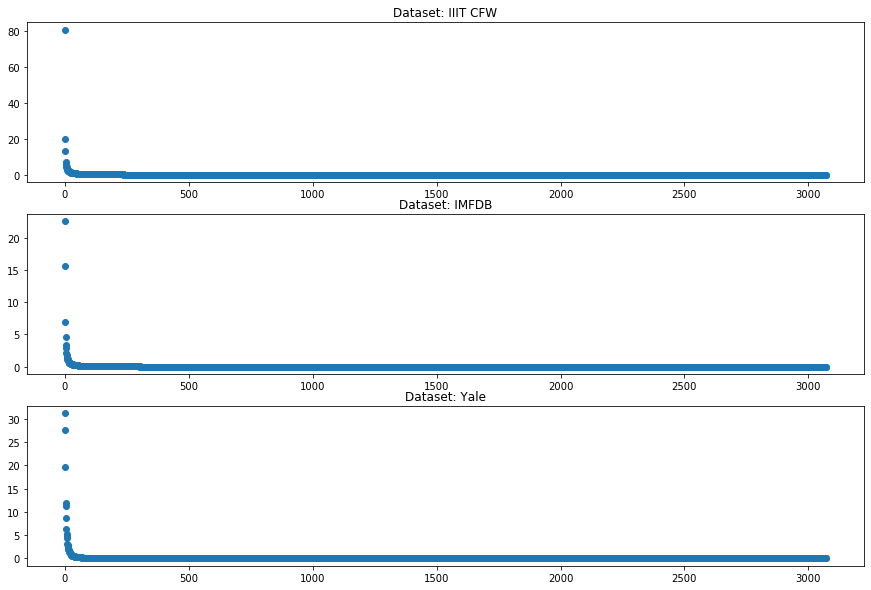

In [139]:
# Plot the eigen value spectrum
fig = plt.figure(figsize=(15, 10))

eig_vals1, eig_vectors1 = np.linalg.eig(np.cov(np.transpose(X_IIIT)))
eig_vals1 = np.real(eig_vals1[eig_vals1.argsort()[::-1]])
num = -1
ax = fig.add_subplot(311)
ax.scatter(np.arange(eig_vals1.shape[0]), eig_vals1)
ax.set_title("Dataset: IIIT CFW")
for i in range(eig_vals1.shape[0]):
    curr_sum = np.sum(eig_vals1[:i+1])
    if curr_sum >= 0.9 * np.sum(eig_vals1) :
        num = i+1
        break
limit1 = num
print(num, " eigen vectors are enough to reconstruct the dataset with at most 10% loss for the IIIT CFW dataset")


eig_vals2, eig_vectors2 = np.linalg.eig(np.cov(np.transpose(X_IMFDB)))
eig_vals2 = np.real(eig_vals2[eig_vals2.argsort()[::-1]])
num = -1
ax = fig.add_subplot(312)
ax.scatter(np.arange(eig_vals2.shape[0]), eig_vals2)
ax.set_title("Dataset: IMFDB")
for i in range(eig_vals2.shape[0]):
    curr_sum = np.sum(eig_vals2[:i+1])
    if curr_sum >= 0.9 * np.sum(eig_vals2):
        num = i+1
        break
limit2 = num
print(num, " eigen vectors are enough to reconstruct the dataset with at most 10% loss for the IMFDB dataset")

eig_vals3, eig_vectors3 = np.linalg.eig(np.cov(np.transpose(X_Yale)))
eig_vals3 = np.real(eig_vals3[eig_vals3.argsort()[::-1]])
num = -1
ax = fig.add_subplot(313)
ax.scatter(np.arange(eig_vals3.shape[0]), eig_vals3)
ax.set_title("Dataset: Yale")
for i in range(eig_vals3.shape[0]):
    curr_sum = np.sum(eig_vals3[:i+1])
    if curr_sum >= 0.9 * np.sum(eig_vals3):
        num = i+1
        break
limit3 = num
print(num, " eigen vectors are enough to reconstruct the dataset with at most 10% loss for the Yale dataset")

1(c). Reconstruct  the  image  back for each case


In [140]:
def reconstruct_images(X, k):
    """
        Reconstruct the images back by just using the selected principal components. 


        You have to write the code in this code block.
        You can change the functions provided above (eg, get_pca, get_lda) for your use case. 
            
        @params: 
                Input parameters

        @return reconstructed_X => reconstructed image
        
    """
    eig_vals, eig_vectors = np.linalg.eig(np.cov(np.transpose(X)))
    reconstructed_X = np.matmul((np.matmul((X-np.mean(X, axis=0)), eig_vectors[:, eig_vals.argsort()[::-1][:k]])), np.transpose(eig_vectors[:, eig_vals.argsort()[::-1][:k]])) + np.mean(X, axis=0)
    return np.real(reconstructed_X)

In [141]:
X_reconstructed_IIIT = reconstruct_images(X_IIIT, limit1)
print("Reconstruction Loss for IIIT CFW Dataset =", np.sqrt(np.mean((X_IIIT - X_reconstructed_IIIT)**2)))

X_reconstructed_IMFDB = reconstruct_images(X_IMFDB, limit2)
print("Reconstruction Loss for IMFDB Dataset =", np.sqrt(np.mean((X_IMFDB - X_reconstructed_IMFDB)**2)))

X_reconstructed_Yale = reconstruct_images(X_Yale, limit3)
print("Reconstruction Loss for Yale Dataset =", np.sqrt(np.mean((X_Yale - X_reconstructed_Yale)**2)))

Reconstruction Loss for IIIT CFW Dataset = 0.09564079372336755
Reconstruction Loss for IMFDB Dataset = 0.05452537682212698
Reconstruction Loss for Yale Dataset = 0.07626541240034536


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


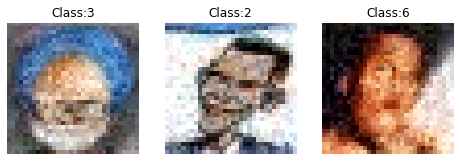

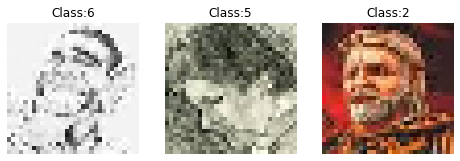

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


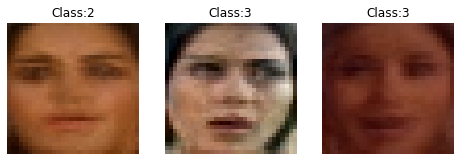

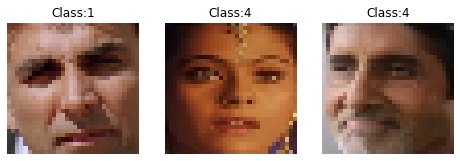

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


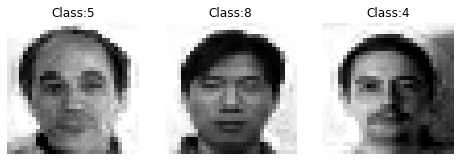

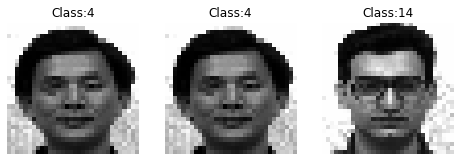

In [160]:
#random images

disply_images(X_reconstructed_IIIT[np.random.randint(0, y_IIIT.shape[0], 3),...].reshape((np.random.randint(0, y_IIIT.shape[0], 3).shape[0], H1, W1, C1)), y_IIIT[np.random.randint(0, y_IIIT.shape[0], 3)], row=1, col=3)
disply_images(X_IIIT[np.random.randint(0, y_IIIT.shape[0], 3),...].reshape((ind.shape[0], H1, W1, C1)), y_IIIT[np.random.randint(0, y_IIIT.shape[0], 3)], row=1, col=3)

disply_images(X_reconstructed_IMFDB[np.random.randint(0, y_IMFDB.shape[0], 3),...].reshape((np.random.randint(0, y_IMFDB.shape[0], 3).shape[0], H2, W2, C2)), y_IMFDB[np.random.randint(0, y_IMFDB.shape[0], 3)], row=1, col=3)
disply_images(X_IMFDB[ind,...].reshape((np.random.randint(0, y_IMFDB.shape[0], 3).shape[0], H2, W2, C2)), y_IMFDB[np.random.randint(0, y_IMFDB.shape[0], 3)], row=1, col=3)

disply_images(X_reconstructed_Yale[np.random.randint(0, y_Yale.shape[0], 3),...].reshape((np.random.randint(0, y_Yale.shape[0], 3).shape[0], H3, W3, C3)), y_Yale[np.random.randint(0, y_Yale.shape[0], 3)], row=1, col=3)
disply_images(X_Yale[np.random.randint(0, y_Yale.shape[0], 3),...].reshape((ind.shape[0], H3, W3, C3)), y_Yale[np.random.randint(0, y_Yale.shape[0], 3)], row=1, col=3)

1(d). Which person/identity is difficult to represent com-pactly with fewer eigen vectors?  Why is that?  Explain with your empirical observations and intuitive answers

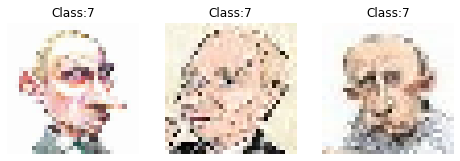

Person belonging to class: 7 is difficult to reconstruct for the IIIT CFW dataset


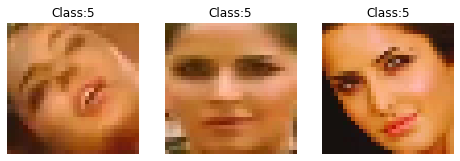

Person belonging to class: 5 is difficult to reconstruct for the IMFDB dataset


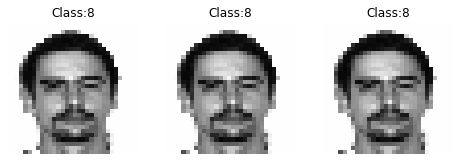

Person belonging to class: 8 is difficult to reconstruct for the Yale dataset


In [157]:
# code goes here
def findClass(X, y, k, H, W, C):
    eig_vals, eig_vectors = np.linalg.eig(np.cov(np.transpose(X)))
    idx = eig_vals.argsort()[::-1][:k]
    ret = 0
    loss = 0
    eig_vectors = np.real(eig_vectors[:, idx])
    for i in np.unique(y):
        idx = np.where(y == i)
        curr_loss = np.sqrt(np.mean((X[idx] - np.matmul((np.matmul((X[idx] - np.mean(X[idx], axis=0)), eig_vectors)), np.transpose(eig_vectors)) + np.mean(X[idx], axis=0))**2))
        if curr_loss > loss:
            ret = i
            loss = curr_loss
    idx = np.where(y == ret)
    ind = np.random.randint(0, y[idx].shape[0],3)
    disply_images(X[idx][ind,...].reshape((ind.shape[0], H, W, C)), y[idx][ind], row=1, col=3)
    return ret

print("Person belonging to class:", findClass(X_IIIT, y_IIIT, limit1, H1, W1, C1),"is difficult to reconstruct for the IIIT CFW dataset")
print("Person belonging to class:", findClass(X_IMFDB, y_IMFDB, limit2, H2, W2, C2),"is difficult to reconstruct for the IMFDB dataset")
print("Person belonging to class:", findClass(X_Yale, y_Yale, limit3, H3, W3, C3),"is difficult to reconstruct for the Yale dataset")

2(a). Use any classifier(MLP, Logistic regression, SVM, Decision Trees) and find the classification accuracy. 

2(b)Which method works well? Do a comparitivestudy. 

- LDA+KLDA gives consistently good results for all datasets with each classifier. 
- VGG anf ResNet combination also gives high accuracy in some cases, but not consistently.
- Classification model wise, SVM and MLP, when used with all features, give 100% accuracy
- If we do not use all features, LR still gives consistently good results


You already know the paper [Face Recognition Us-ing  Kernel  Methods](!http://face-rec.org/algorithms/Kernel/nips01.pdf) .See  this  as  an  example for empirical analysis of different features/classification.

In [158]:
# Define your classifier here. You can use libraries like sklearn to create your classifier 
class Classifier():
            
    def validate(self,X_validate,y_validate):
        conf_mat = confusion_matrix(y_validate, self.model.predict(X_validate))
        valid_accur = (np.where(self.model.predict(X_validate) == y_validate)[0].shape[0] / y_validate.shape[0]) * 100
        precision = precision_score(y_validate, self.model.predict(X_validate), average='macro')
        recall = recall_score(y_validate, self.model.predict(X_validate), average='macro')
        f1 = f1_score(y_validate, self.model.predict(X_validate), average='macro')
        return conf_mat, valid_accur, precision, recall, f1
    
    def train(self,X_train,y_train):
        self.model.fit(X_train,y_train)
    
    def __init__(self,cl):
        if cl == 'MLP':
            self.model = MLPClassifier(hidden_layer_sizes = (64,32), max_iter = 1000)
        elif cl == 'LR':
            self.model = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial')
        elif cl == 'SVC':
            self.model = SVC(C=1.0, kernel='rbf')
        else:
            raise TypeError
    

In [167]:
# Create a train and validation split to train your classifier 

def get_f1(X, y, model, final_dataframe):
    dframe = final_dataframe
    train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=0.2)
    model.train(train_x, train_y)
    f1 = model
    conf_mat, accuracy, precision, recall, f1 = model.validate(test_x, test_y)
    final_dataframe.append([test_x.shape[1], accuracy, precision, recall, f1])
    return f1, conf_mat

    
def compare_classifiers(X, y, dataset_name, k, dir_path):
         
    max_f1= -1
    index={  0:'PCA + Resnet + MLP',1:'KPCA + KLDA + MLP',
             2:'LDA + KLDA + MLP',3:'VGG + Resnet + MLP',4:'All + MLP',
             5:'PCA + Resnet + SVM',6:'KPCA + KLDA + SVM',
             7:'LDA + KLDA + SVM',8:'VGG + Resnet + SVM',9:'All + SVM',
             10:'PCA + Resnet + LR',11:'KPCA + KLDA + LR',
             12:'LDA + KLDA + LR',13:'VGG + Resnet + LR',14:'All + LR'}
    best_conf_mat = []
    final_dataframe = []
    f1_score = -1
    
    for cl in ['MLP', 'SVC', 'LR']:
        
        model = Classifier(cl)
        data, data2 = get_vgg_features(dir_path), get_resnet_features(dir_path)  
        
        X1 = np.concatenate((get_pca(X, k), get_resnet_features(dir_path)), axis=1)
        f1max = f1_score
        f1_score1, conf_mat1 = get_f1(X1, y, model, final_dataframe)
        if f1_score1 > max_f1 :
            max_f1 = f1_score1
            best_conf_mat = conf_mat1
        
        X2 = np.concatenate((get_kernel_pca(X, k), get_kernel_lda(X, y, k)), axis=1)
        f1max = f1_score
        f1_score2, conf_mat2 = get_f1(X2, y, model, final_dataframe)
        if f1_score2 > max_f1 :
            max_f1 = f1_score2
            best_conf_mat = conf_mat2
        
        X3 = np.concatenate((data, data2), axis=1)
        f1max = f1_score
        f1_score3, conf_mat3 = get_f1(X3, y, model, final_dataframe)
        if f1_score3 > max_f1 :
            max_f1 = f1_score3
            best_conf_mat = conf_mat3        
        
        X4 = np.concatenate((get_lda(X, y, k),get_kernel_lda(X, y, k)),axis=1)
        f1max = f1_score
        f1_score4, conf_mat4 = get_f1(X4, y, model, final_dataframe)
        if f1_score4 > max_f1 :
            max_f1 = f1_score4
            best_conf_mat = conf_mat4        
        
        X5 = np.concatenate((get_pca(X, k), get_kernel_pca(X, k), get_lda(X, y, k),get_kernel_lda(X, y, k), get_vgg_features(dir_path), get_resnet_features(dir_path)), axis=1)
        f1max = f1_score
        f1_score5, conf_mat5 = get_f1(X5, y,model, final_dataframe)       
        if f1_score5 > max_f1 :
            max_f1 = f1_score5
            best_conf_mat = conf_mat5    

            
    df = pd.DataFrame(final_dataframe, columns=['Reduced Space', 'Validation Accuracy', 'Precision', 'Recall', 'F1-score'])
    df.rename(index,inplace=True)
    df.name = "***Results for Dataset:" + dataset_name + "***"
    return pd.DataFrame(best_conf_mat),df

lim = limit1
conf_mat_IIIT_CFW, df_IIIT_CFW = compare_classifiers(X_IIIT, y_IIIT, 'IIIT-CFW', lim, './dataset/IIIT-CFW/')
lim = limit2
conf_mat_IMFDB, df_IMFDB = compare_classifiers(X_IMFDB, y_IMFDB, 'IMFDB', lim, './dataset/IMFDB/')
lim = limit3
conf_mat_Yale, df_Yale = compare_classifiers(X_Yale, y_Yale, 'Yale_face_database', lim, './dataset/Yale_face_database/')

In [169]:
# Create 3 tables simiar to page-6 of the paper. One table per dataset 

"***Results for Dataset: IIIT - CFW ***"
display(Markdown("***Results for Dataset: IIIT-CFW ***"), df_IIIT_CFW)
display(Markdown("***Results for Dataset: IMFDB ***"), df_IMFDB)
display(Markdown("***Results for Dataset:Yale_face_database ***"), df_Yale)

***Results for Dataset: IIIT-CFW ***

,Reduced Space,Validation Accuracy,Precision,Recall,F1-score
PCA + Resnet + MLP,2256,97.777778,0.969314,0.982500,0.975013
KPCA + KLDA + MLP,215,97.037037,0.962545,0.969066,0.965205
LDA + KLDA + MLP,6144,96.296296,0.967313,0.959936,0.961284
VGG + Resnet + MLP,14,97.777778,0.978919,0.957341,0.964735
All + MLP,6574,98.518519,0.981818,0.977885,0.979593
PCA + Resnet + SVM,2256,98.518519,0.986842,0.991071,0.988614
KPCA + KLDA + SVM,215,97.037037,0.968892,0.976366,0.971942
LDA + KLDA + SVM,6144,98.518519,0.975446,0.980429,0.976777
VGG + Resnet + SVM,14,94.814815,0.927885,0.929134,0.927087
All + SVM,6574,100.000000,1.000000,1.000000,1.000000


***Results for Dataset: IMFDB ***

,Reduced Space,Validation Accuracy,Precision,Recall,F1-score
PCA + Resnet + MLP,2115,96.25,0.959416,0.961164,0.958690
KPCA + KLDA + MLP,74,95.00,0.947974,0.956981,0.948386
LDA + KLDA + MLP,6144,97.50,0.977273,0.978220,0.977249
VGG + Resnet + MLP,14,96.25,0.964773,0.961648,0.962360
All + MLP,6292,97.50,0.977083,0.977273,0.975486
PCA + Resnet + SVM,2115,96.25,0.968324,0.969406,0.967067
KPCA + KLDA + SVM,74,98.75,0.987500,0.989583,0.987986
LDA + KLDA + SVM,6144,97.50,0.981456,0.977273,0.977870
VGG + Resnet + SVM,14,97.50,0.974330,0.969643,0.971532
All + SVM,6292,98.75,0.988636,0.991667,0.989737


***Results for Dataset:Yale_face_database ***

,Reduced Space,Validation Accuracy,Precision,Recall,F1-score
PCA + Resnet + MLP,2083,96.969697,0.911111,0.933333,0.920000
KPCA + KLDA + MLP,49,100.000000,1.000000,1.000000,1.000000
LDA + KLDA + MLP,6144,96.969697,0.964286,0.976190,0.961905
VGG + Resnet + MLP,28,100.000000,1.000000,1.000000,1.000000
All + MLP,6242,100.000000,1.000000,1.000000,1.000000
PCA + Resnet + SVM,2083,100.000000,1.000000,1.000000,1.000000
KPCA + KLDA + SVM,49,100.000000,1.000000,1.000000,1.000000
LDA + KLDA + SVM,6144,96.969697,0.976190,0.964286,0.961905
VGG + Resnet + SVM,28,90.909091,0.966667,0.922222,0.928889
All + SVM,6242,100.000000,1.000000,1.000000,1.000000


***Results for Dataset:IIIT-CFW***

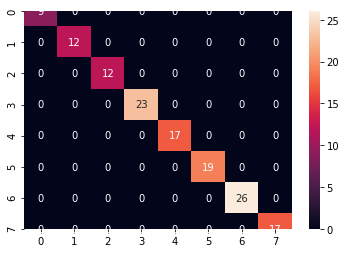

***Results for Dataset:IMFDB***

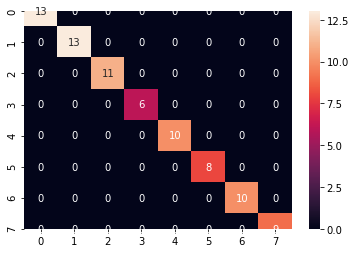

***Results for Dataset:Yale_face_database***

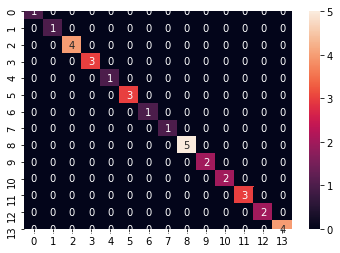

In [168]:
# For each dataset print the confusion matrix for the best model 

print_conf_mat(conf_mat_IIIT_CFW, df_IIIT_CFW.name)
print_conf_mat(conf_mat_IMFDB, df_IMFDB.name)
print_conf_mat(conf_mat_Yale, df_Yale.name)

def print_conf_mat(conf_mat, mat_name):
    display(Markdown(mat_name))
    fig = plt.figure()
    sns.heatmap(conf_mat,annot=True)
    plt.show()

3. Similiar to 1(b) use t-SNE based visilization of faces?  Does it makesense?  Do you see similar people coming together?or something else?  Can you do visualization datasetwise and combined? Here you will use a popular implementation.(Worth  reading and understanding  t-SNE.  We  will not discuss it in the class and out of scope for thiscourse/exams.

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 672 samples in 0.038s...
[t-SNE] Computed neighbors for 672 samples in 1.758s...
[t-SNE] Computed conditional probabilities for sample 672 / 672
[t-SNE] Mean sigma: 5.174227
[t-SNE] KL divergence after 250 iterations with early exaggeration: 67.126541
[t-SNE] KL divergence after 300 iterations: 1.628715
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 400 samples in 0.018s...
[t-SNE] Computed neighbors for 400 samples in 0.574s...
[t-SNE] Computed conditional probabilities for sample 400 / 400
[t-SNE] Mean sigma: 7.078774
[t-SNE] KL divergence after 250 iterations with early exaggeration: 100.576813
[t-SNE] KL divergence after 300 iterations: 3.109822
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 165 samples in 0.000s...
[t-SNE] Computed neighbors for 165 samples in 0.003s...
[t-SNE] Computed conditional probabilities for sample 165 / 165
[t-SNE] Mean sigma: 5.362611
[t-SNE] KL divergence after 250 iteration

Text(0.5, 0.92, 'Dataset: All')

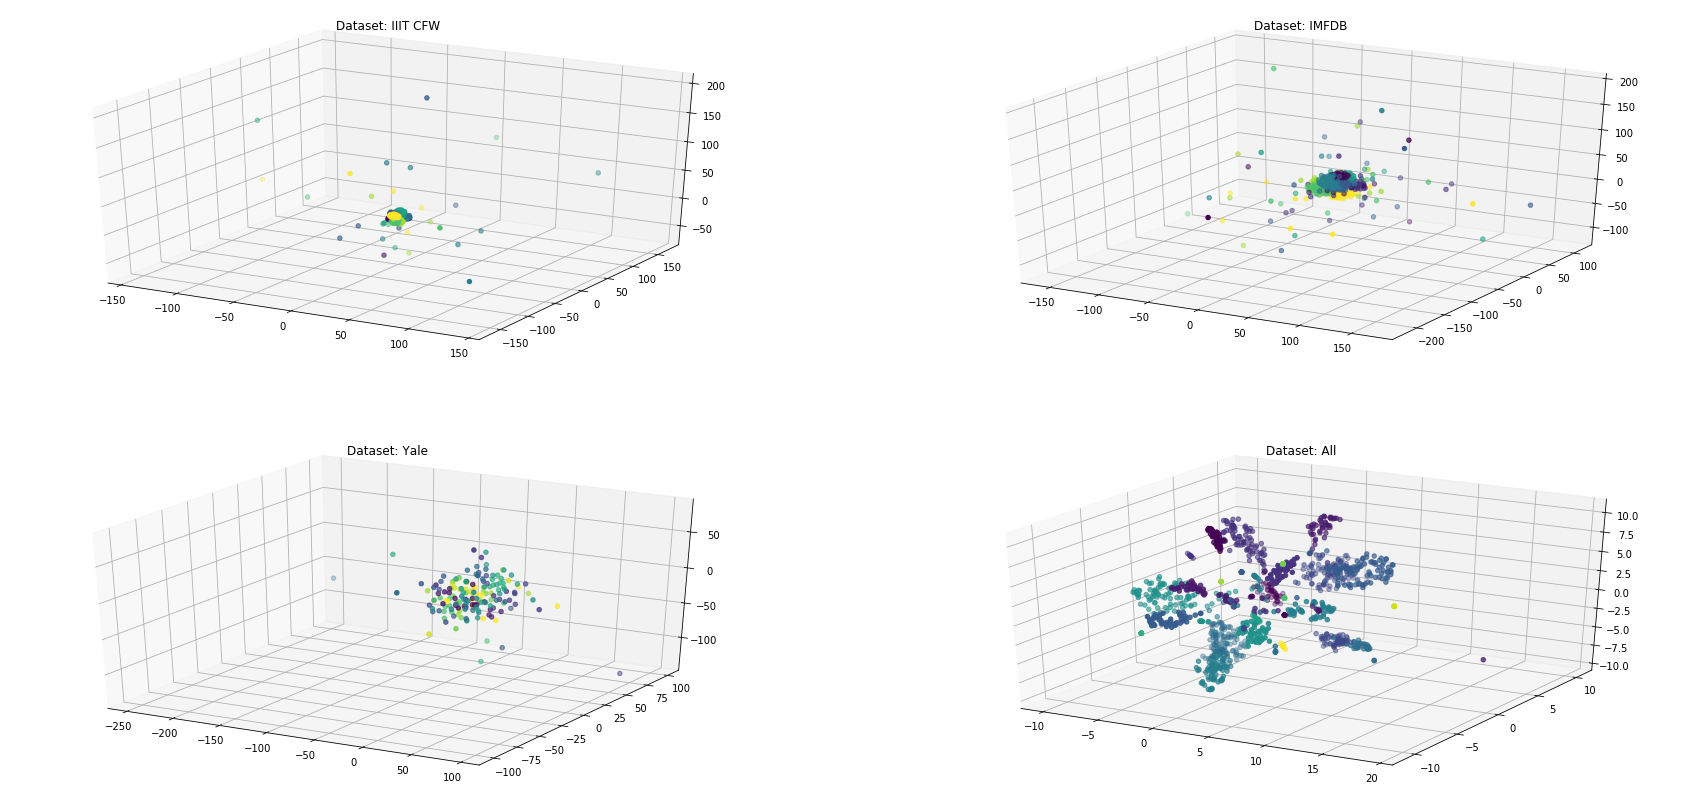

In [179]:
fig = plt.figure(figsize=(30, 30))

fig_num = 1
X_TSNE1 = TSNE(n_components=3,verbose=1, n_iter=300).fit_transform(get_resnet_features('./dataset/IIIT-CFW/'))
ax = fig.add_subplot(421, projection='3d')
ax.scatter(X_TSNE1[:,0], X_TSNE1[:,1], X_TSNE1[:,2],c = y_IIIT)
ax.set_title("Dataset: IIIT CFW")

fig_num = 2
X_TSNE2 = TSNE(n_components=3,verbose=1, n_iter=300).fit_transform(get_resnet_features('./dataset/IMFDB/'))
ax = fig.add_subplot(422, projection='3d')
ax.scatter(X_TSNE2[:,0], X_TSNE2[:,1], X_TSNE2[:,2],c = y_IMFDB)
ax.set_title("Dataset: IMFDB")

fig_num = 3
X_TSNE3 = TSNE(n_components=3,verbose=1, n_iter=300).fit_transform(get_resnet_features('./dataset/Yale_face_database/'))
ax = fig.add_subplot(423, projection='3d')
ax.scatter(X_TSNE3[:,0], X_TSNE3[:,1], X_TSNE3[:,2],c = y_Yale)
ax.set_title("Dataset: Yale")

fig_num = 4
X_TSNE4 = TSNE(n_components=3,verbose=1, n_iter=300).fit_transform(np.concatenate((get_resnet_features('./dataset/IIIT-CFW/'), get_resnet_features('./dataset/IMFDB/'), get_resnet_features('./dataset/Yale_face_database/'))))
ax = fig.add_subplot(424, projection='3d')
ax.scatter(X_TSNE4[:,0], X_TSNE4[:,1], X_TSNE4[:,2],c = np.concatenate((y_IIIT, y_IMFDB, y_Yale)))
ax.set_title("Dataset: All")



[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 672 samples in 0.030s...
[t-SNE] Computed neighbors for 672 samples in 1.615s...
[t-SNE] Computed conditional probabilities for sample 672 / 672
[t-SNE] Mean sigma: 5.174227
[t-SNE] KL divergence after 250 iterations with early exaggeration: 55.610359
[t-SNE] KL divergence after 300 iterations: 0.542904
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 400 samples in 0.013s...
[t-SNE] Computed neighbors for 400 samples in 0.532s...
[t-SNE] Computed conditional probabilities for sample 400 / 400
[t-SNE] Mean sigma: 7.078774
[t-SNE] KL divergence after 250 iterations with early exaggeration: 55.132618
[t-SNE] KL divergence after 300 iterations: 0.297166
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 165 samples in 0.000s...
[t-SNE] Computed neighbors for 165 samples in 0.003s...
[t-SNE] Computed conditional probabilities for sample 165 / 165
[t-SNE] Mean sigma: 5.362611
[t-SNE] KL divergence after 250 iterations

Text(0.5, 1.0, 'All')

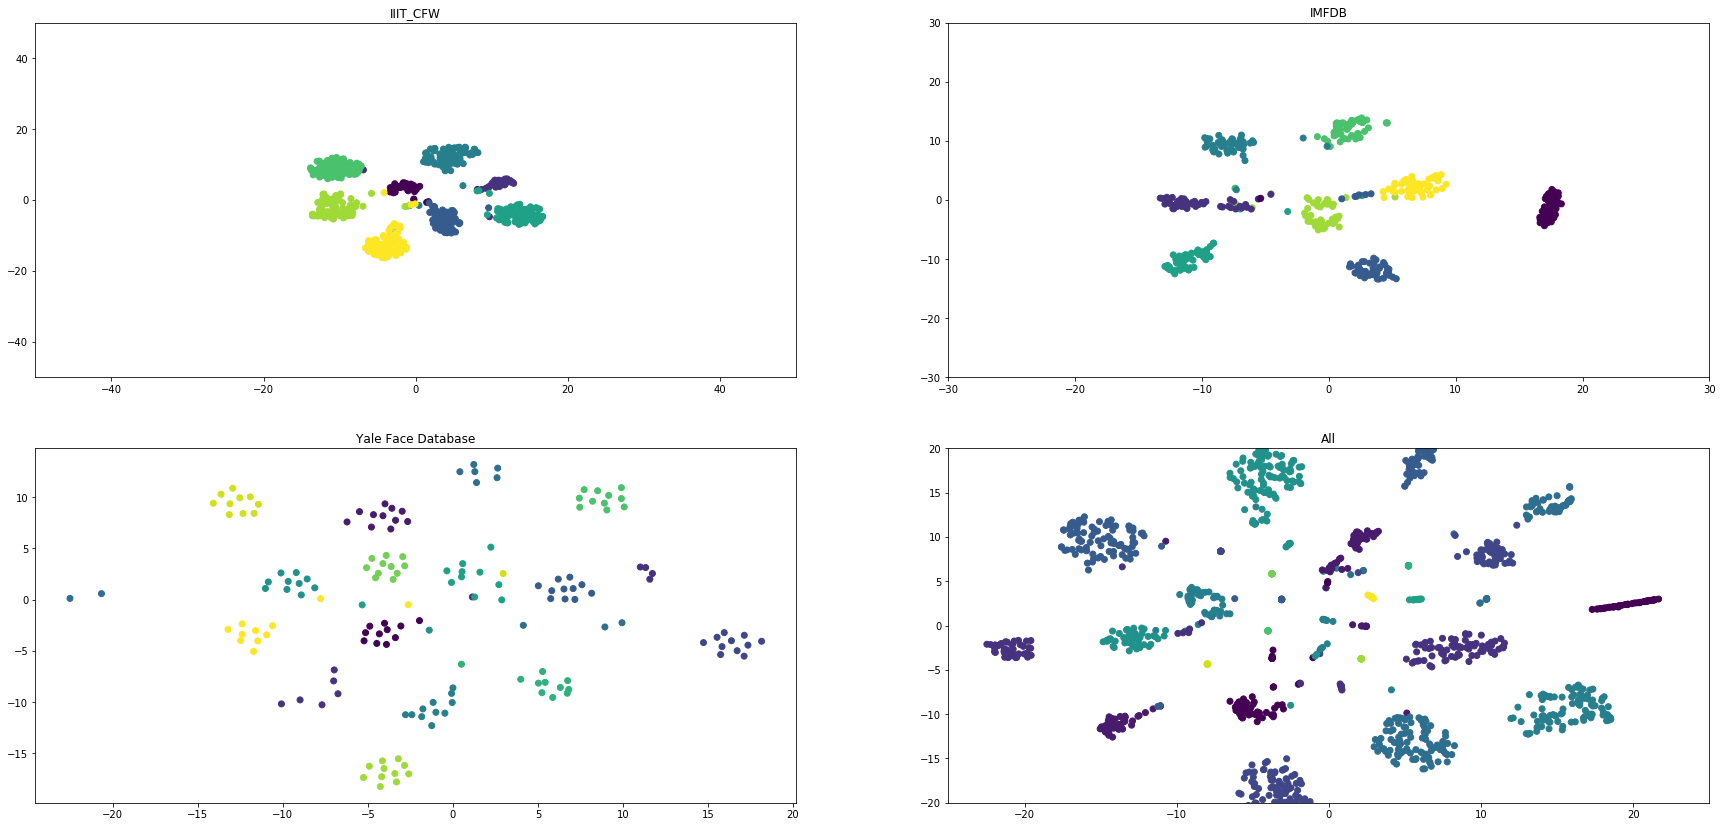

In [180]:

fig = plt.figure(figsize=(30, 30))

fig_num = 1
tsne_0 = TSNE(n_components=2,verbose=1, n_iter=300).fit_transform(get_resnet_features('./dataset/IIIT-CFW/'))
ax = fig.add_subplot("421")
ax.scatter(tsne_0[:, 0], tsne_0[:, 1], c = y_IIIT)
ax.set_xlim([-50, 50])
ax.set_ylim([-50, 50])
ax.set_title("IIIT_CFW")

fig_num = 2
tsne_1 = TSNE(n_components=2,verbose=1, n_iter=300).fit_transform(get_resnet_features('./dataset/IMFDB/'))
ax = fig.add_subplot("422")
ax.scatter(tsne_1[:, 0], tsne_1[:, 1], c = y_IMFDB)
ax.set_xlim([-30, 30])
ax.set_ylim([-30, 30])
ax.set_title("IMFDB")

tsne_2 = TSNE(n_components=2,verbose=1, n_iter=300).fit_transform(get_resnet_features('./dataset/Yale_face_database/'))
ax = fig.add_subplot("423")
fig_num = 3
ax.scatter(tsne_2[:, 0], tsne_2[:, 1], c = y_Yale)
ax.set_title("Yale Face Database")

fig_num = 4
tsne_t = TSNE(n_components=2,verbose=1, n_iter=300).fit_transform(np.concatenate((get_resnet_features('./dataset/IIIT-CFW/'), get_resnet_features('./dataset/IMFDB/'), get_resnet_features('./dataset/Yale_face_database/'))))
ax = fig.add_subplot("424")
ax.scatter(tsne_t[:, 0], tsne_t[:, 1], c = np.concatenate((y_IIIT, y_IMFDB, y_Yale)))
ax.set_xlim([-25, 25])
ax.set_ylim([-20, 20])
ax.set_title("All")


4.`face`  is  used  for  verification.   

4(a) How do we formulate the problem using KNN 

- We project the images on a reduced dimension space (say by PCA or LDA). 
- We take all the images in our training set and project them in this reduced dimensional space.
- Now, for each image in the test set, we project it in this space, and calculate the K nearest neighbours of this point. 
- Whichever label has a majority among these K neighbours, we assign that label to our test sample

4(b) How do we analyze the performance ? suggest  the  metrics  (like  accuracy) that is appropriate for this task.

- We can use metrics like accuracy to find out the % of correct classifications. We can also look at f1 score.
_______________________________________________________________________

4(c)Show empirical re-sults  with  all  the  representations

### Extenstion / Application
    Create a system for any one of the following problems:

- Politicians  vs  Filmstars  in  a  public  data  set.   (eg.LFW)
        You already have seen IIIT-CFW dataset. Use it for classification. 
- Age prediction
        Given different actors/actress in IMFDB create new labels based on their age.  
- Gender prediction
        Given different actors/actress in IMFDB+IIIT-CFW create new labels based on their gender.
- Emotion classification
        Both the yale dataset and IMFDB contain an `emotion.txt` file. Using that you can create a emotion predicter 
- cartoon vs real images
        Use a combination of IIIT-CFW and other dataset. 
        


You are free to use a new dataset that is publicly avail-able or even create one by crawling from internet.

In [ ]:
# Load data

In [ ]:
# Define your features

In [ ]:
# Create your classifier

# Validate your classifier

In [ ]:
# Show qualitative results such as accuracy, k-fold validation, TSNE/PCA/Isomap plots, etc.  

In [ ]:
# Show quantitative results such as examples of correct prediction and wrong prediction